Sometimes we need to install some dependant libraries. This can be run once per session, or as required

In [2]:
!pip install openpyxl

Now we can import the libraries that we will use from here on.

In [3]:
# for making the initial data table
import json
import pandas as pd
import numpy as np
from extract import Extractor # loads its own dependencies

# for applying the algorithm
from extract import getTestTrain
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_error

# for examining the performance
import matplotlib.pyplot as plt

Once that is done, we can go ahead and merge some of the existing data tables / files in a single one that fits our requirements. This only needs to be run once initially, or as desired to change the table.

Note that the warning is a false positive.

In [3]:
# Begin with the root folder that all of the data will be under
root = "../shared_lancuni_grp_prj_2021/data"

# load the json file to use as a lookup
neighboursPath = f"{root}/raw/gis/gis_ltla_neighbours.json"
neighbours = None
with open(neighboursPath, "r") as jsonIn:
    neighbours = json.load(jsonIn)

# set up the extractor
e = Extractor(root)

# merge the two tables
casesFile = "raw/cases_ltla_2021-12-11.csv"
vaccFile = "raw/vacc_ltla_2021-12-11.csv"

# define the mapping for columns in each table which match (PK / UK)
keys = [
    ['areaCode', 'areaName', 'areaType', 'date'],
    ['areaCode', 'areaName', 'areaType', 'date']
]

# load and merge the files
e.loadFile(casesFile)
e.importColumns(vaccFile, keys)

# split date into month and year

# clean up
columns = ['areaCode',
           'areaName',
           'areaType',
           'date',
           'cases',
           'age',
           'cumVaccinationCompleteCoverageByVaccinationDatePercentage']
e.filterTable(columns)
e.deduplicate()

# get our merged table out
df = e.getTable()

# remove all of the age groups (i.e. set to 00_59
ageRanges = ["00_59", "60+"]
df = df[df['age'].isin(ageRanges)]

# add neighbour lookup
df['neighbours'] = df.apply(lambda row: neighbours[row['areaCode']], axis=1)
print(df.head())

# split the date into month and year - to account for seasonality
df['Month']= df['date'].str.split('-').str[1]
df['Year']= df['date'].str.split('-').str[0]

# put it back into the extractor
e.setTable(df)

# output
outPath = "../data/table.csv"
e.saveTable(outPath)

    areaCode              areaName areaType        date    age  cases  \
0  E06000003  Redcar and Cleveland     ltla  2021-12-06  00_04      2   
1  E06000003  Redcar and Cleveland     ltla  2021-12-06  00_59     83   
2  E06000003  Redcar and Cleveland     ltla  2021-12-06  05_09     11   
3  E06000003  Redcar and Cleveland     ltla  2021-12-06  10_14     15   
4  E06000003  Redcar and Cleveland     ltla  2021-12-06  15_19      5   

   rollingSum  rollingRate  VaccineRegisterPopulationByVaccinationDate  \
0           9        129.4                                      124077   
1         492        509.5                                      124077   
2          89       1073.7                                      124077   
3          59        738.4                                      124077   
4          38        546.6                                      124077   

   cumVaccinationCompleteCoverageByVaccinationDatePercentage  
0                                               78.6 

/tmp/ipykernel_136/3449273910.py:48: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['neighbours'] = df.apply(lambda row: neighbours[row['areaCode']], axis=1)


     areaCode              areaName areaType        date  cases    age  \
1   E06000003  Redcar and Cleveland     ltla  2021-12-06     83  00_59   
13  E06000003  Redcar and Cleveland     ltla  2021-12-06      7    60+   
23  E07000040            East Devon     ltla  2021-12-06    105  00_59   
35  E07000040            East Devon     ltla  2021-12-06     12    60+   
45  E07000090                Havant     ltla  2021-12-06    121  00_59   

    cumVaccinationCompleteCoverageByVaccinationDatePercentage  \
1                                                78.6           
13                                               78.6           
23                                               84.3           
35                                               84.3           
45                                               80.8           

                                           neighbours  
1                   [E06000002, E07000164, E07000168]  
13                  [E06000002, E07000164, E07000168

/tmp/ipykernel_136/3449273910.py:52: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Month']= df['date'].str.split('-').str[1]
/tmp/ipykernel_136/3449273910.py:53: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Year']= df['date'].str.split('-').str[0]


We have now created a table which we can use to train the decision tree.

Next we will load that table, split it into test and training sets and apply the algorithm.

The results will also be saved in an intermediate table so that this doesn't have to be run every time.

In [4]:
# the input data file
tablePath = "../data/table.csv"
table = pd.read_csv(tablePath)

# remove any nans
before = table.shape[0]
table = table.dropna()
after = table.shape[0]
print(f"{after - before} rows were dropped due to empty values")

# get a list of each unique area code
areas = table['areaCode'].unique()

# note the columns which are non-numeric. They will require factorising
columnsToFactorise = ['areaCode', 'areaName', 'areaType', 'date', 'age']

# note the performance metrics
metrics = {
    'Area':[],
    'MSE': []
}

# get the data
i = 0
n = len(areas)
for area in areas:
    i += 1

    print(f"Getting the testing and training data for {area}. {i}/{n}")
    toTrain, toPredict = getTestTrain(area, table, columnsToFactorise)
    print(f"train: {toTrain.shape}   predict: {toPredict.shape}")

    # split up the data for testing and training
    trainY = toTrain.loc[:, 'cases']
    trainX = toTrain.drop('cases', axis=1)

    testY = toPredict.loc[:, 'cases']
    testX = toPredict.drop('cases', axis=1)

    # removing empty columns might lead to a lack of test or training data.
    if trainX.shape[0] == 0 or trainY.shape[0] == 0 or testX.shape[0] == 0 or testY.shape[0] == 0:
        print(f"Missing data. Skipping {area}")
        continue

    # set up algorithm(s)
    tree = DecisionTreeRegressor() #KeyError: 'squared_error'

    # Train algorithm (s)
    tree.fit(trainX, trainY)

    # Test algorithm (s)
    predY = expectedCases = tree.predict(testX)

    # output metrics
    mse = mean_squared_error(testY, predY)

    metrics['Area'].append(area)
    metrics['MSE'].append(mse)
    print(f"MSE for {area}: {mse}")

print()
print()
print(metrics)

metrics = pd.DataFrame(metrics)
metrics.to_csv('../data/performance.csv')

-16548 rows were dropped due to empty values
Getting the testing and training data for E06000003. 1/315
train: (2042, 9)   predict: (686, 9)
MSE for E06000003: 925.4897959183673
Getting the testing and training data for E07000040. 2/315
train: (4028, 9)   predict: (672, 9)
MSE for E07000040: 6669.739583333333
Getting the testing and training data for E07000090. 3/315
train: (2690, 9)   predict: (676, 9)
MSE for E07000090: 136.7440828402367
Getting the testing and training data for E07000214. 4/315
train: (4710, 9)   predict: (682, 9)
MSE for E07000214: 202.41348973607037
Getting the testing and training data for E07000229. 5/315
train: (1354, 9)   predict: (672, 9)
MSE for E07000229: 432.1815476190476
Getting the testing and training data for E08000001. 6/315
train: (3390, 9)   predict: (672, 9)
MSE for E08000001: 1377.797619047619
Getting the testing and training data for E08000009. 7/315
train: (2704, 9)   predict: (674, 9)
MSE for E08000009: 974.3605341246291
Getting the testing and

We will now load the results table back in and examine the performance of the algorithm

In [5]:
# load in the results table 
results = pd.read_csv('../data/final_performance.csv')
results["MSE"] = results[['fdecision_MSE', 'fknn_MSE', 'flinear_MSE']].mean(axis=1)
results.head()

,Unnamed: 0,Area,fdecision_MSE,fdecision_r2,fknn_MSE,fknn_r2,flinear_MSE,flinear_r2,MSE
0,0,E06000003,836.590379,0.555964,1298.869621,0.310601,1417.546911,0.247611,1184.335637
1,1,E07000040,5934.647321,-4.723592,2389.419940,-1.304444,740.639088,0.285700,3021.568783
2,2,E07000090,136.337278,0.833524,365.066509,0.554233,517.854261,0.367671,339.752683
3,3,E07000214,177.818182,0.689283,315.430792,0.448820,382.630961,0.331396,291.959978
4,4,E07000229,434.450893,0.267936,406.557143,0.314938,473.349328,0.202391,438.119121


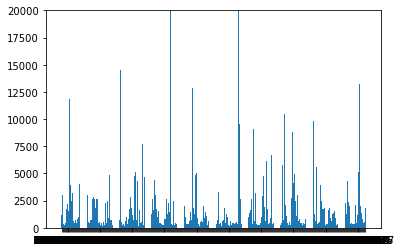

In [7]:
# start with a simple plot
plt.bar(x=results.Area, height=results.MSE)
plt.ylim(top=20000)
plt.savefig("./images/errorsByTrust.png")
#plt.show()

Quantify the errors

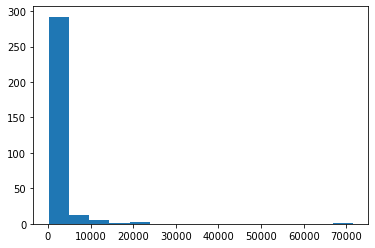

In [12]:
plt.hist(results.MSE, bins=15)
plt.savefig("./images/errorsHist.png")

In [9]:
print(f"Maximum error: {max(results.MSE)}")
print(f"Minimum error: {min(results.MSE)}")
print(f"Average error: {np.mean(results.MSE)}")
print(f"Variance of error: {np.var(results.MSE)}")

Maximum error: 71546.25572662562
Minimum error: 126.57596815125919
Average error: 1967.4952249982566
Variance of error: 22587548.02756681


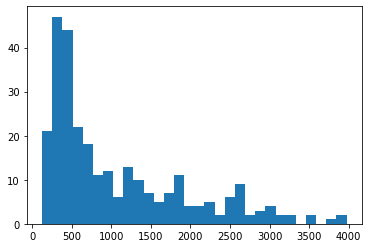

In [13]:
pruned = results[results.MSE < 4000]
plt.hist(pruned.MSE, bins=30)
plt.savefig("./images/zoomedHist.png")